In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,  RobustScaler
import pickle
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M
import numpy as np
import gc


2024-04-16 16:12:44.540594: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 16:12:45.418231: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
FEATURE_COLS = test_df.columns[1:].tolist()



In [3]:
sd_columns = [col for col in train_df.columns if col.endswith('_sd')]
train_df.drop(columns=sd_columns, inplace=True)


In [4]:

train_images_path = './data/train_images/'
test_images_path = './data/test_images/'    

train_df['image_path'] = train_df['id'].apply(lambda x: os.path.join(train_images_path, f'{x}.jpeg'))
test_df['image_path'] = test_df['id'].apply(lambda x: os.path.join(test_images_path, f'{x}.jpeg'))


In [5]:



def plot_data(df, columns_names):
    plt.figure(figsize=(15, 3))

    # Setting up a grid of plots with 2 columns
    n_cols = 6
    n_rows = len(columns_names) // n_cols + (len(columns_names) % n_cols > 0)

    for i, col in enumerate(columns_names):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=False, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
    


In [6]:
train_df[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,55489.000000,5.548900e+04,5.548900e+04,55489.000000,5.548900e+04,5.548900e+04
mean,0.522575,1.325267e+02,1.969902e+04,13.528574,3.459399e+03,3.975552e+05
std,0.174853,1.278220e+04,2.309747e+06,1356.480785,2.471919e+05,9.152463e+07
min,-2.431157,6.780000e-05,2.330000e-08,0.000097,5.500000e-07,7.690000e-08
25%,0.410995,1.063987e+01,3.102831e-01,1.173489,5.613414e-01,2.552815e+02
50%,0.509009,1.511232e+01,7.156651e-01,1.480060,2.519985e+00,7.244318e+02
75%,0.622383,1.968160e+01,3.586311e+00,1.926343,1.491886e+01,2.148630e+03
max,4.475172,1.504254e+06,2.720494e+08,159759.897700,3.106555e+07,2.155911e+10


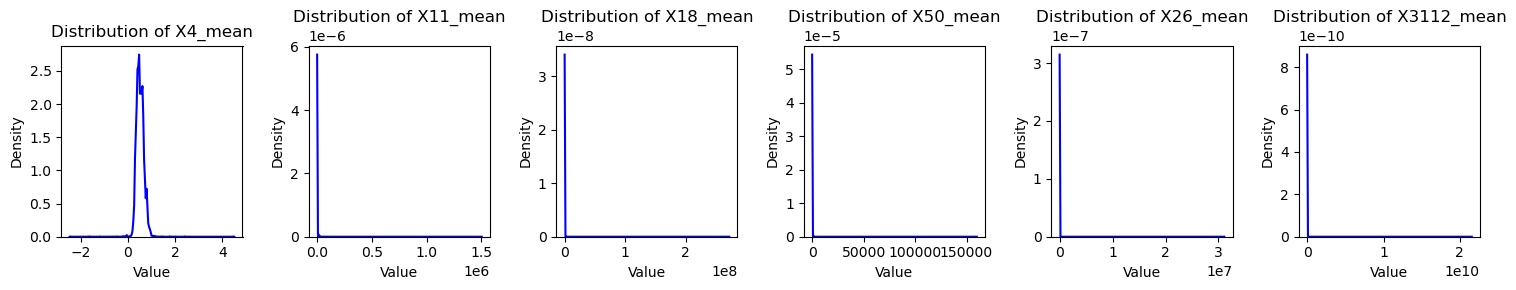

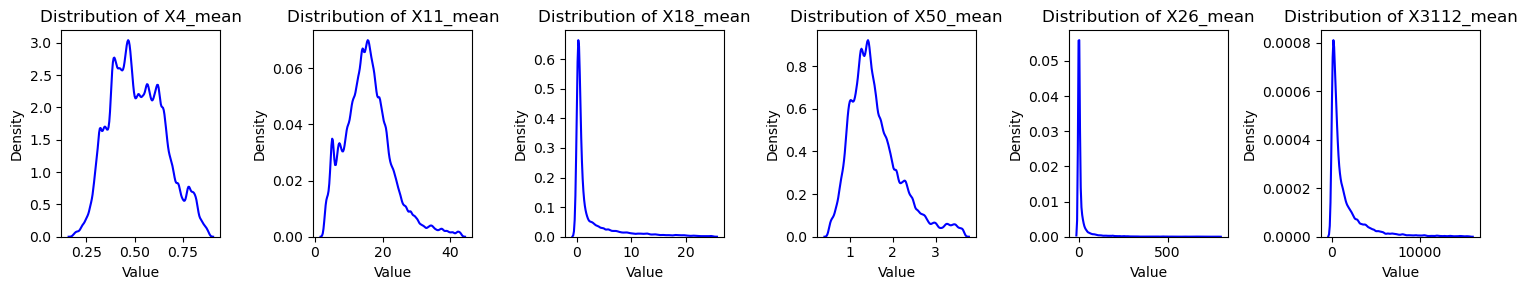

In [7]:
plot_data(train_df, mean_columns)

for column in mean_columns:
    lower_quantile = train_df[column].quantile(0.005)
    upper_quantile = train_df[column].quantile(0.985)  
    train_df = train_df[(train_df[column] >= lower_quantile) & (train_df[column] <= upper_quantile)]
    

plot_data(train_df, mean_columns)

In [8]:
train_df[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000
mean,0.516058,15.752458,2.772597,1.592122,24.176388,1598.763010
std,0.138489,6.961194,4.549765,0.588147,72.898061,2271.015359
min,0.181879,2.836897,0.033326,0.510491,0.005874,10.527904
25%,0.408995,11.060960,0.306775,1.185120,0.544728,263.122005
50%,0.502897,15.296873,0.676143,1.471036,2.289064,694.205681
75%,0.616053,19.505972,2.962085,1.886668,12.249738,1964.239682
max,0.883987,43.206557,24.975647,3.677128,785.944393,15639.231100


In [9]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, trait in enumerate(mean_columns):

    # Determine the bin edges dynamically based on the distribution of traits
    bin_edges = np.percentile(train_df[trait], np.linspace(0, 100, 5 + 1))
    train_df[f"bin_{i}"] = np.digitize(train_df[trait], bin_edges)

# Concatenate the bins into a final bin
train_df["final_bin"] = (
    train_df[[f"bin_{i}" for i in range(len(mean_columns))]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
train_df = train_df.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df["final_bin"])):
    train_df.loc[valid_idx, "fold"] = fold



/home/tobias/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [10]:

batch_size = 64

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


base_model = EfficientNetV2M(weights='imagenet', include_top=False, pooling='avg')
base_model.trainable = False

def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (480, 480))
    
    return img


def extract_features_batch(image_paths):
    img_batch = np.stack([load_and_preprocess_image(img_path) for img_path in image_paths])
    features = base_model.predict(img_batch, batch_size=batch_size)  
    return features

image_paths = train_df['image_path'].values

features_list = []
j = 0
for i in range(0, len(image_paths), batch_size):
    batch_paths = image_paths[i:i+batch_size]
    batch_features = extract_features_batch(batch_paths)
    features_list.append(batch_features)
    j += 1
    if j % 30 == 0:
        tf.keras.backend.clear_session()
        gc.collect()
        print(f'Clearing session')

all_features = np.vstack(features_list)
train_df['features_avg'] = list(all_features)




2024-04-16 16:12:52.223613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 16:12:52.463741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 16:12:52.463811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 16:12:52.467171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 16:12:52.467249: I tensorflow/compile

1/1 [==============================] - 0s 160ms/step
Clearing session
1/1 [==============================] - 0s 135ms/step
Clearing session
1/1 [==============================] - 0s 147ms/step
Clearing session
1/1 [==============================] - 0s 170ms/step
Clearing session
1/1 [==============================] - 0s 249ms/step
Clearing session
1/1 [==============================] - 0s 154ms/step
Clearing session
1/1 [==============================] - 0s 137ms/step
Clearing session
1/1 [==============================] - 0s 170ms/step
Clearing session
1/1 [==============================] - 0s 186ms/step
Clearing session
1/1 [==============================] - 0s 160ms/step
Clearing session
1/1 [==============================] - 0s 165ms/step
Clearing session
1/1 [==============================] - 0s 129ms/step
Clearing session
1/1 [==============================] - 0s 330ms/step
Clearing session
1/1 [==============================] - 0s 134ms/step
Clearing session
1/1 [===============

In [11]:

batch_size = 64

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


base_model = EfficientNetV2M(weights='imagenet', include_top=False, pooling='max')
base_model.trainable = False

def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (480, 480))
    
    return img


def extract_features_batch(image_paths):
    img_batch = np.stack([load_and_preprocess_image(img_path) for img_path in image_paths])
    features = base_model.predict(img_batch, batch_size=batch_size)  
    return features

image_paths = train_df['image_path'].values

features_list = []
j = 0
for i in range(0, len(image_paths), batch_size):
    batch_paths = image_paths[i:i+batch_size]
    batch_features = extract_features_batch(batch_paths)
    features_list.append(batch_features)
    j += 1
    if j % 30 == 0:
        tf.keras.backend.clear_session()
        gc.collect()
        print(f'Clearing session')

all_features = np.vstack(features_list)
train_df['features_max'] = list(all_features)




1/1 [==============================] - 0s 101ms/step
Clearing session
1/1 [==============================] - 0s 129ms/step
Clearing session
1/1 [==============================] - 0s 130ms/step
Clearing session
1/1 [==============================] - 0s 97ms/step
Clearing session
1/1 [==============================] - 0s 120ms/step
Clearing session
1/1 [==============================] - 0s 112ms/step
Clearing session
1/1 [==============================] - 0s 104ms/step
Clearing session
1/1 [==============================] - 0s 133ms/step
Clearing session
1/1 [==============================] - 0s 153ms/step
Clearing session
1/1 [==============================] - 0s 126ms/step
Clearing session
1/1 [==============================] - 0s 104ms/step
Clearing session
1/1 [==============================] - 0s 157ms/step
Clearing session
1/1 [==============================] - 0s 135ms/step
Clearing session
1/1 [==============================] - 0s 96ms/step
Clearing session
1/1 [=================

In [12]:
print(train_df.head())
print(train_df.describe())
print(train_df.info())

          id  WORLDCLIM_BIO1_annual_mean_temperature  \
0  192027691                               12.235703   
1  195542235                               17.270555   
2  196639184                               14.254504   
3  195728812                               18.680834   
4  195251545                                0.673204   

   WORLDCLIM_BIO12_annual_precipitation  \
0                            374.466675   
1                             90.239998   
2                            902.071411   
3                           1473.933350   
4                            530.088867   

   WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                          62.524445                       
1                                          10.351111                       
2                                          49.642857                       
3                                         163.100006                       
4                       

In [13]:
train_df['features'] = train_df.apply(lambda x: np.concatenate([x['features_avg'], x['features_max']]), axis=1)

In [14]:
print(train_df['features'].head())
print(train_df['features'].iloc[0].shape)
print(train_df.info())


0    [-0.04898902, -0.04436887, -0.098530695, -0.06...
1    [-0.038196847, -0.034478754, -0.091713466, -0....
2    [-0.042443186, -0.039298795, -0.09362312, -0.0...
3    [-0.047844898, -0.046239335, -0.10041175, -0.0...
4    [-0.043499608, -0.041672133, -0.0968142, -0.06...
Name: features, dtype: object
(2560,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49168 entries, 0 to 49167
Columns: 182 entries, id to features
dtypes: float64(49), int64(128), object(5)
memory usage: 68.3+ MB
None


In [15]:
import pickle

# Specify the file path to save the pickle file
pickle_file_path = './data/train_df.pickle'

# Save the train_df dataframe as a pickle file
with open(pickle_file_path, 'wb') as f:
    pickle.dump(train_df, f)


In [16]:

batch_size = 64

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


base_model = EfficientNetV2M(weights='imagenet', include_top=False, pooling='avg')
base_model.trainable = False

def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (480, 480))
    
    return img


def extract_features_batch(image_paths):
    img_batch = np.stack([load_and_preprocess_image(img_path) for img_path in image_paths])
    features = base_model.predict(img_batch)        
    return features

image_paths = test_df['image_path'].values

features_list = []
j = 0
for i in range(0, len(image_paths), batch_size):
    batch_paths = image_paths[i:i+batch_size]
    batch_features = extract_features_batch(batch_paths)
    features_list.append(batch_features)
    j += 1
    if j % 30 == 0:
        tf.keras.backend.clear_session()
        gc.collect()
        print(f'Clearing session')

all_features = np.vstack(features_list)
test_df['features_avg'] = list(all_features)




2/2 [==============================] - 0s 251ms/step
Clearing session
2/2 [==============================] - 0s 249ms/step
Clearing session
2/2 [==============================] - 0s 251ms/step
Clearing session
1/1 [==============================] - 4s 4s/step


In [17]:

batch_size = 64

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

base_model = EfficientNetV2M(weights='imagenet', include_top=False, pooling='max')
base_model.trainable = False

def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (480, 480))
    
    return img


def extract_features_batch(image_paths):
    img_batch = np.stack([load_and_preprocess_image(img_path) for img_path in image_paths])
    features = base_model.predict(img_batch)        
    return features

image_paths = test_df['image_path'].values

features_list = []
j = 0
for i in range(0, len(image_paths), batch_size):
    batch_paths = image_paths[i:i+batch_size]
    batch_features = extract_features_batch(batch_paths)
    features_list.append(batch_features)
    j += 1
    if j % 30 == 0:
        tf.keras.backend.clear_session()
        gc.collect()
        print(f'Clearing session')

all_features = np.vstack(features_list)
test_df['features_max'] = list(all_features)




2/2 [==============================] - 1s 512ms/step
Clearing session
2/2 [==============================] - 1s 516ms/step
Clearing session
2/2 [==============================] - 0s 254ms/step
Clearing session
1/1 [==============================] - 3s 3s/step


In [18]:
print(test_df.shape)
print(test_df.head())

(6545, 167)
          id  WORLDCLIM_BIO1_annual_mean_temperature  \
0  201238668                                8.086756   
1  202310319                               10.844286   
2  202604412                                8.105556   
3  201353439                                7.077679   
4  195351745                                4.790555   

   WORLDCLIM_BIO12_annual_precipitation  \
0                           2246.500000   
1                            495.871429   
2                            378.328583   
3                            878.785706   
4                           2299.366699   

   WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                         127.321426                       
1                                          28.023809                       
2                                          39.928570                       
3                                          70.428574                       
4           

In [19]:
test_df['features'] = test_df.apply(lambda x: np.concatenate([x['features_avg'], x['features_max']]), axis=1)

In [20]:
print(test_df['features'].head())
print(test_df['features'].iloc[0].shape)
print(test_df.info())


0    [-0.045153886, -0.04233732, -0.09827553, -0.06...
1    [-0.046340186, -0.0431469, -0.09931696, -0.065...
2    [-0.045467574, -0.043343674, -0.099074945, -0....
3    [-0.045607973, -0.042786438, -0.09776302, -0.0...
4    [-0.04078627, -0.03710904, -0.0939908, -0.0578...
Name: features, dtype: object
(2560,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6545 entries, 0 to 6544
Columns: 168 entries, id to features
dtypes: float64(42), int64(122), object(4)
memory usage: 8.4+ MB
None


In [21]:
pickle_file_path = './data/test_df.pickle'

# # Save the train_df dataframe as a pickle file
with open(pickle_file_path, 'wb') as f:
    pickle.dump(test_df, f)

test_df.head()

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,image_path,features_avg,features_max,features
0,201238668,8.086756,2246.500000,127.321426,20.423418,353.381042,17.535713,80,109,90,...,0.363712,0.364623,0.379435,0.388294,0.398887,0.397853,./data/test_images/201238668.jpeg,"[-0.045153886, -0.04233732, -0.09827553, -0.06...","[15.876948, 20.303545, 14.665901, 18.000998, 1...","[-0.045153886, -0.04233732, -0.09827553, -0.06..."
1,202310319,10.844286,495.871429,28.023809,18.738306,786.554382,29.292856,130,155,142,...,0.291168,0.280947,0.277623,0.276503,0.271212,0.272672,./data/test_images/202310319.jpeg,"[-0.046340186, -0.0431469, -0.09931696, -0.065...","[15.89867, 20.24581, 14.652087, 17.930191, 15....","[-0.046340186, -0.0431469, -0.09931696, -0.065..."
2,202604412,8.105556,378.328583,39.928570,41.885647,722.071167,34.853809,133,134,139,...,0.445230,0.435441,0.432758,0.429839,0.417250,0.394216,./data/test_images/202604412.jpeg,"[-0.045467574, -0.043343674, -0.099074945, -0....","[15.563358, 19.74785, 14.182922, 17.405441, 15...","[-0.045467574, -0.043343674, -0.099074945, -0...."
3,201353439,7.077679,878.785706,70.428574,37.045235,669.389343,25.150000,103,140,116,...,0.513455,0.519174,0.474007,0.469071,0.408466,0.366724,./data/test_images/201353439.jpeg,"[-0.045607973, -0.042786438, -0.09776302, -0.0...","[15.922542, 20.202469, 14.519055, 17.911919, 1...","[-0.045607973, -0.042786438, -0.09776302, -0.0..."
4,195351745,4.790555,2299.366699,150.199997,24.136568,462.887695,22.516666,85,114,98,...,0.358262,0.369279,0.414420,0.469002,0.519534,0.521837,./data/test_images/195351745.jpeg,"[-0.04078627, -0.03710904, -0.0939908, -0.0578...","[16.414492, 20.860716, 15.032074, 18.579977, 1...","[-0.04078627, -0.03710904, -0.0939908, -0.0578..."
